In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
# функция обратная бокса-кокса!
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Сделаем визуализацию 

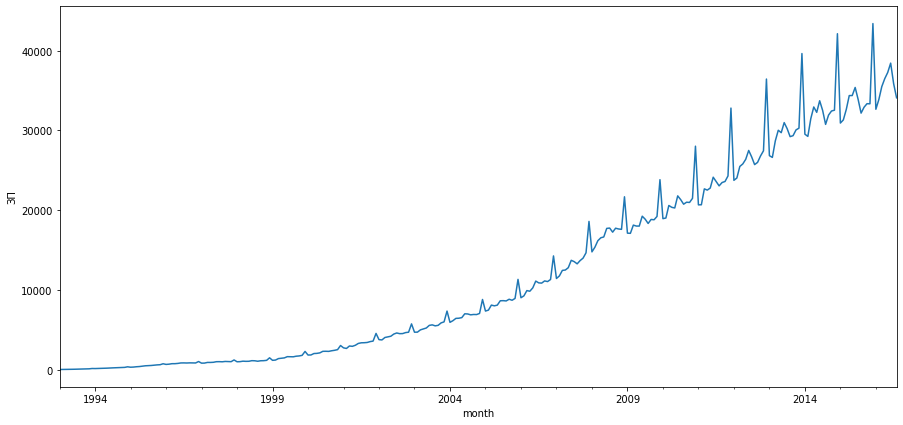

In [9]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('ЗП')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x504 with 0 Axes>

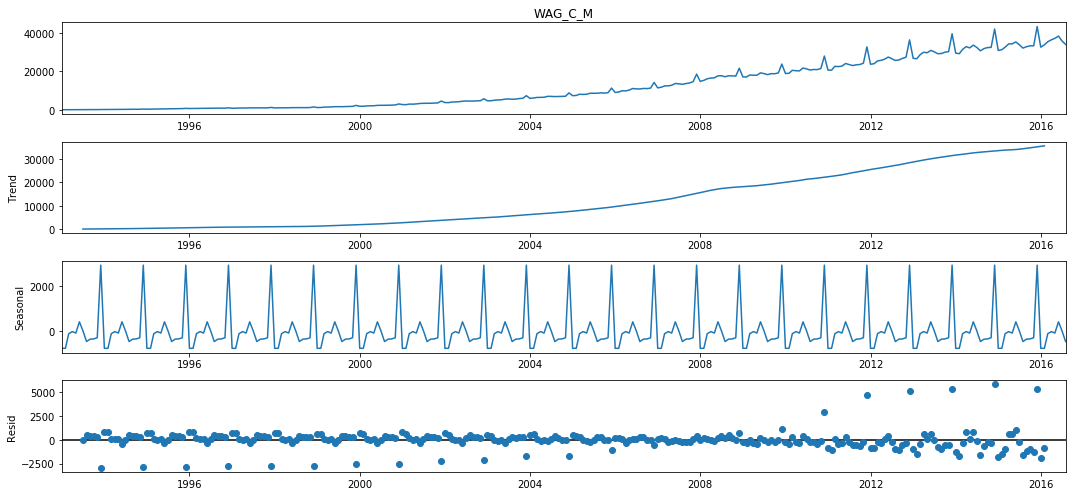

In [14]:
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Выводы: 
- ряд нестационарный, так критерий Дики-Фуллера больше 0.05.
- Есть тренд и сезонность.
- Ряд монотонно меняет дисперсию, значит нужно применить преобразования Бокса-Кокса 

In [15]:
# Сделаем преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


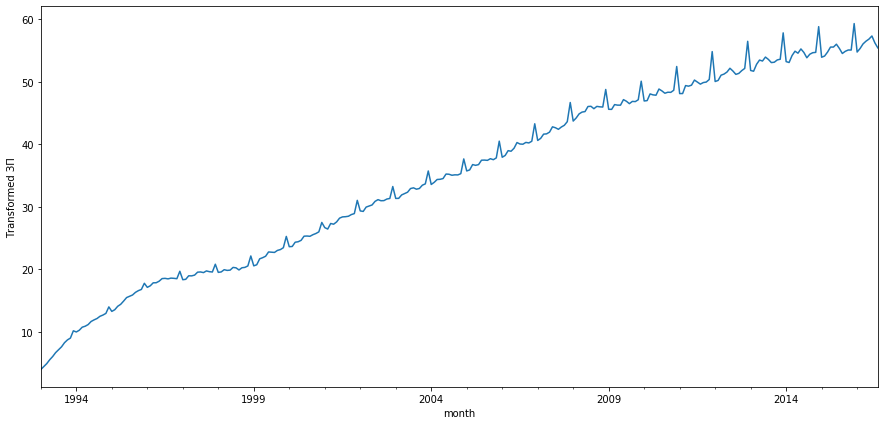

In [18]:
data['new_WAG_C_M'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.new_WAG_C_M.plot()
plt.ylabel(u'Transformed ЗП')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.new_WAG_C_M)[1])

Ряд досих пор нестациорный

### Выполним дифф. сезонное и если понадобиться обычное

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

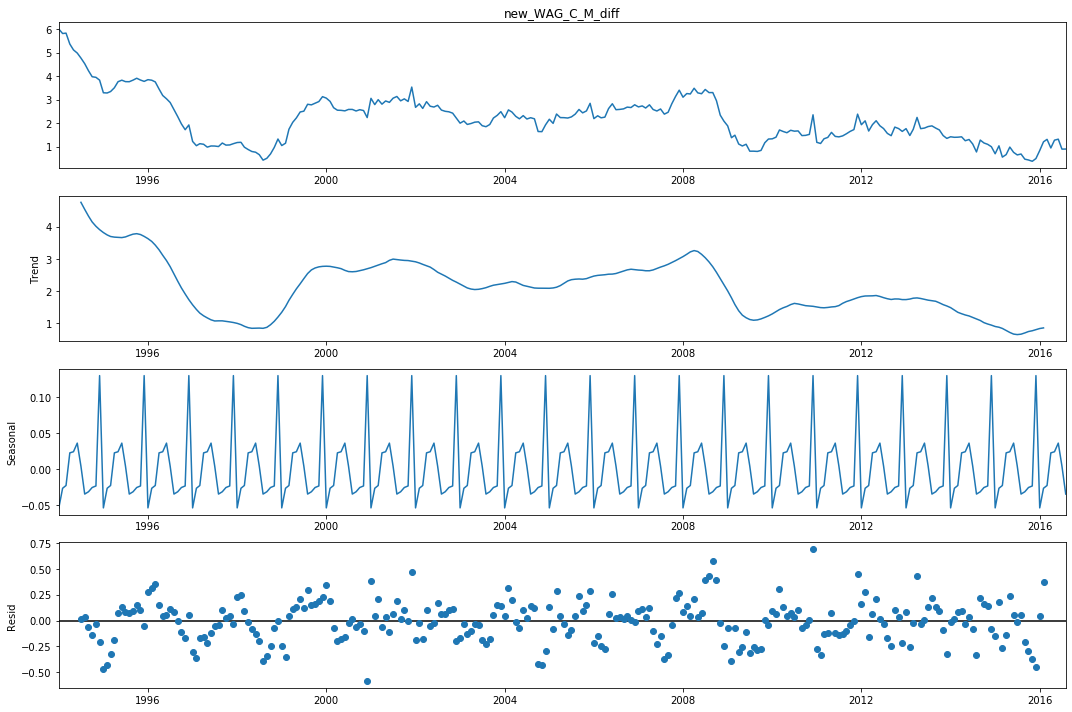

In [24]:
data['new_WAG_C_M_diff'] = data.new_WAG_C_M - data.new_WAG_C_M.shift(12) 
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.new_WAG_C_M_diff.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.new_WAG_C_M_diff.dropna())[1])
data['new_WAG_C_M_diff'] = data.new_WAG_C_M_diff.dropna()

In [26]:
# уже лучше, но тренд все равно остался, все таки сделаем дифф обычное. 

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

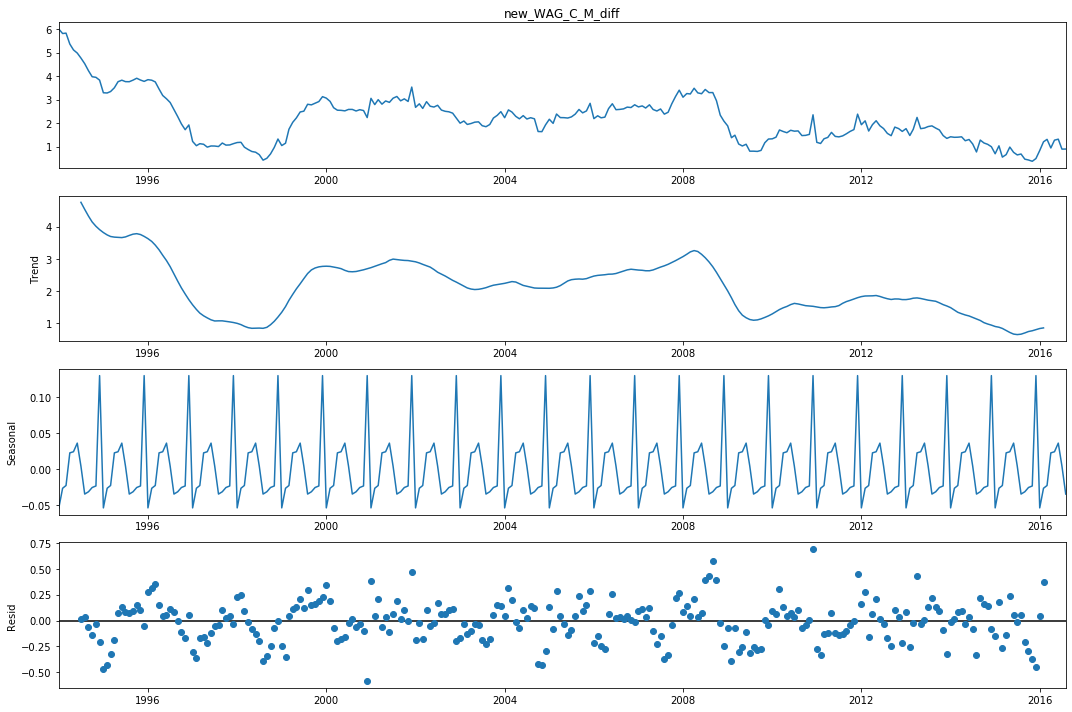

In [30]:
data['new_WAG_C_M_diff2'] = data.new_WAG_C_M_diff - data.new_WAG_C_M_diff.shift(1) 
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.new_WAG_C_M_diff.dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.new_WAG_C_M_diff2.dropna())[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет.

### Подберем по ACF и PACF значения p P Q q

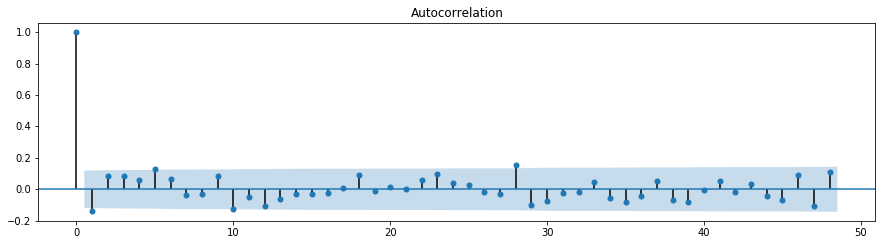

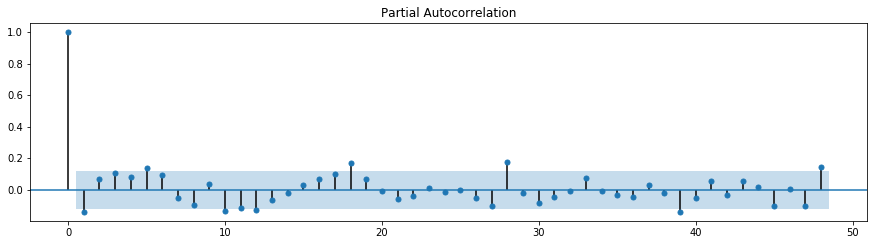

In [32]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.new_WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.new_WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

#### Начальные приближения: Q=0, q=1, P=1, p=1

In [54]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [55]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

### Обучим модель ARIMA c различными значениями и выберим лучшую

In [56]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.new_WAG_C_M, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print ('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 11.5 s, sys: 196 ms, total: 11.7 s
Wall time: 3.79 s


In [57]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
10  (1, 0, 1, 0)  0.340521
11  (1, 0, 1, 1)  0.492413
9   (1, 0, 0, 1)  0.774438
6   (0, 1, 1, 0)  1.170769
7   (0, 1, 1, 1)  1.342395


In [58]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        new_WAG_C_M   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Wed, 05 Aug 2020   AIC                              0.341
Time:                                    23:56:52   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

In [60]:
# Посмотрим на остатки

Критерий Стьюдента: p=0.090795
Критерий Дики-Фуллера: p=0.000003


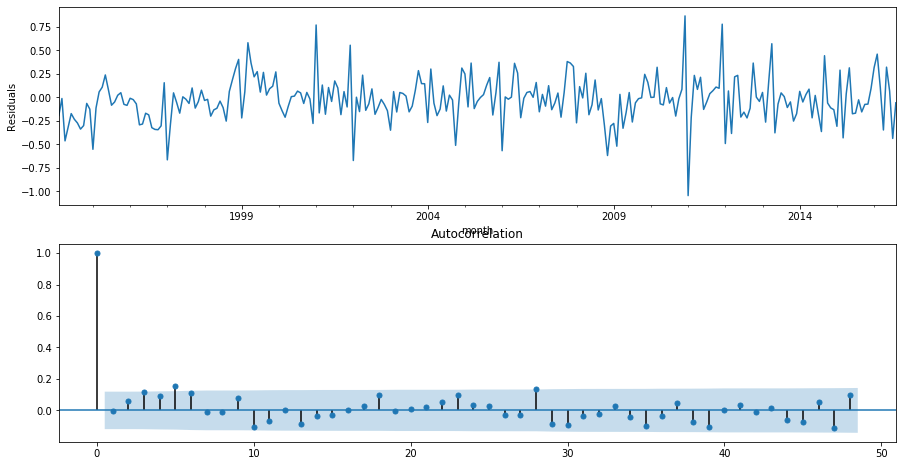

In [61]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print ("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

#### Анализ остатков построенной модели
Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:


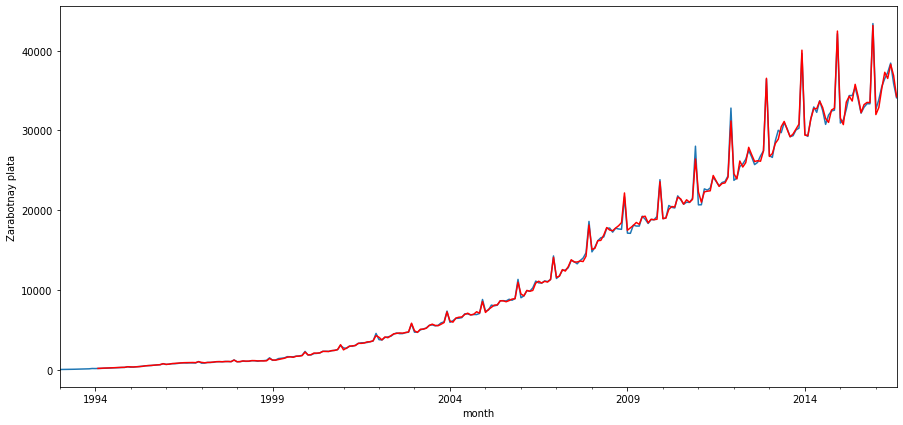

In [62]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel(u'Zarabotnay plata')
pylab.show()

### Сделаем прогноз на 2 года

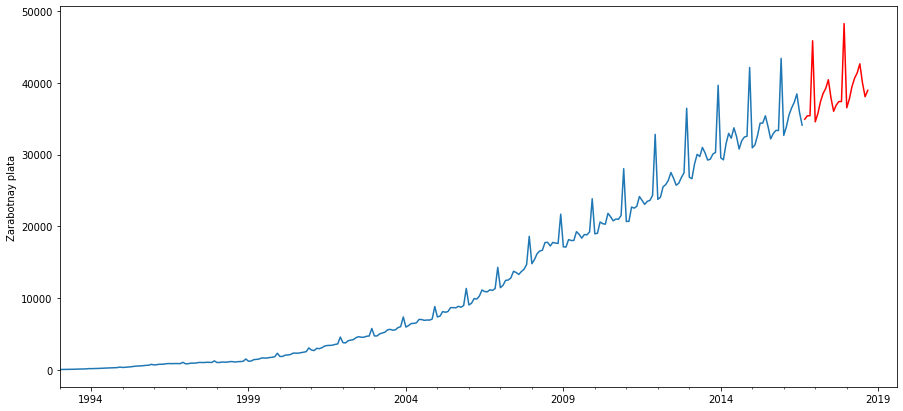

In [64]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=data.shape[0] + 24), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel(u'Zarabotnay plata')
pylab.show()